# Project Overview


## 1. Import Python Packages
Importing machine learning Python packages. Python packages such as Numpy, Pandas, Scikit-learn they are design to run in single-core hence when the data is too large they may require a machine with a very large RAM. In this project, we are using images with 1500 x 1500 x 3 dimensions therefore Deep Learning Python frameworcks such as Tensorflow and Keras for faster image processing, training and predictions.

### 1.1 Data Structure
```
.
├dataset            
└── train         <- consists of 131 images
├── train_labels  <- consists of 131 corresponding masks/labels
├── val           <- consists of 10 images
├── val_labels    <- consists of 10 corresponding masks/labels    
├── test          <- consists of 10 images
├── test_labels   <- consists of 10 corresponding masks/labels

```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install cachier

     |████████████████████████████████| 81kB 3.7MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=c114012f853e5a471ef1686e559a7610d4319dc40edd96e701afc42a986b5767
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built pathtools


In [ ]:
cd /content/drive/MyDrive/compute_vision/buildings_segmentation


/content/drive/MyDrive/compute_vision/buildings_segmentation


In [ ]:
import natsort
from natsort import natsorted
import os
import re
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import networkx as nx
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.preprocessing import image
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras import backend as K
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import sklearn.neighbors
import time
import imageio
import cv2 as cv
import skimage
from skimage import img_as_float32, img_as_ubyte, img_as_uint
from skimage.feature import canny
from skimage.color import rgb2gray, rgb2hsv, gray2rgb, rgba2rgb
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)
# caching with sane defaults
from cachier import cachier
cachier = partial(cachier, pickle_reload=False, cache_dir='data/cache')
# define the seed to make sure that we are consistently getting the same results
seed = 42
np.random.seed = seed
ROOT_DIR = os.getcwd()

### 1.2 Instantiate Dataset Path

In [ ]:
# get images and corressponding masks
TRAIN_DATA_PATH = list(zip(
    natsorted(glob('dataset/train/*.png')),
    natsorted(glob('dataset/train_labels/*.png')),
))

# get val images and corresponding masks
VAL_DATA_PATH= list(zip(
    natsorted(glob('dataset/val/*.png')),
    natsorted(glob('dataset/val_labels/*.png')),
))

# get test images and corresponding masks
TEST_DATA_PATH= list(zip(
    natsorted(glob('dataset/test/*.png')),
    natsorted(glob('dataset/test_labels/*.png')),
))

## 2. Image Preprocessing

In [ ]:
class ImagePreProcessing(object):
    """
    This is a blueprint for image processing
    """
    
    def __init__(self, IMAGES = None, MASKS = None):
        """
        This method initiates the constructor which assigns values to data members of the class when aan  object is created
        """
        self.SIZE = (512,512)
        self.IMAGES = []
        self.MASKS = []
        self.IMAGES_CHANNELS = 3
        self.MASKS_CHANNEL = 1
        
    def get_images(self, PATH):
        """
        This method loads and converts images as a color image
        :params:  path to buildings ariel images
        :returns: images as numpy array
        """
        
        # read all images and store them in an array. 
        # borrowed from https://realpython.com/storing-images-in-python/
        for img_path, _ in tqdm(PATH, "Loading images"):
            
            # load images as float32 and store it in an array
            image = img_as_float32(cv.imread(img_path, cv.IMREAD_COLOR))
            
            # downsample the input image to 512 x 512 x 3
            image = cv.resize(image, self.SIZE)
            
            # convert images to color images since opencv reads images grayscale
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            
            # store all images
            self.IMAGES.append(image)
            
        # convert image to a numpy array
        IMGS = np.array(self.IMAGES)
        
        # check if all images have the same size and color images (RGB with 3 channels)
        assert IMGS.shape == (len(self.IMAGES), self.SIZE[0], self.SIZE[1], self.IMAGES_CHANNELS)
   
        return IMGS
            
            
    def get_masks(self, 
                  PATH):
        """
        This method loads and converts images as a grayscale image
        :params: path to buildings masks
        :returns: masks as a numpy array      
        """
        
        # read all images and store them in an array. 
        # borrowed from https://realpython.com/storing-images-in-python/
        for _, msk_path  in tqdm(PATH, "Loading masks"):
            
            # load images as float32 and store it in an array
            mask = img_as_float32(cv.imread(msk_path, cv.IMREAD_COLOR))
            
            # downsample the input image to 512 x 512 
            mask= cv.resize(mask, self.SIZE)
            
            # convert masks to grayscale 
            mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
            
            # store all masks
            self.MASKS.append(mask)
            
        # convert masks to a numpy array
        MSKS = np.array(self.MASKS)
        
        # expand the dimensions of the masks
        MSKS = np.expand_dims(MSKS, axis=3)
        
        # check if all masks have the same size
        assert MSKS.shape == (len(self.MASKS), self.SIZE[0], self.SIZE[1], self.MASKS_CHANNEL)
                
        return MSKS
    
    def get_dimensions(self):
        """
        This method gets dimensions of both the images and masks after downsampling
        :return: images and masks dimensions
        """     

        print("\n", "(1500, 1500, 3) ","=>", self.SIZE[0], self.SIZE[1], self.IMAGES_CHANNELS)
        print('\n', "1500, 1500) ", "=>", self.SIZE[0], self.SIZE[1], self.MASKS_CHANNEL)

### 2.1 Load Images and Masks

#### 2.1.1 Load training images and corresponding masks

In [ ]:
# get image preprocessing object
buildings_segmentation =  ImagePreProcessing()
# loads train images
train_images = buildings_segmentation.get_images(TRAIN_DATA_PATH)

Loading images: 100%|██████████| 131/131 [04:24<00:00,  2.02s/it]


In [ ]:
# get image preprocessing object
buildings_segmentation =  ImagePreProcessing()
# loads corresponding traing masks
train_masks = buildings_segmentation.get_masks(TRAIN_DATA_PATH)

Loading masks: 100%|██████████| 131/131 [01:09<00:00,  1.89it/s]


#### 2.1.2 Load validation images and corresponding masks

In [ ]:
# get image preprocessing object
buildings_segmentation =  ImagePreProcessing()
# loads validation images
val_images = buildings_segmentation.get_images(VAL_DATA_PATH)

Loading images: 100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


In [ ]:
# get image preprocessing object
buildings_segmentation =  ImagePreProcessing()
# load validation masks
val_masks = buildings_segmentation.get_masks(VAL_DATA_PATH)

Loading masks: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


#### 2.1.3 Load test images and corresponding masks

In [ ]:
# get image preprocessing object
buildings_segmentation =  ImagePreProcessing()
# load test images
test_images = buildings_segmentation.get_images(TEST_DATA_PATH)

Loading images: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


In [ ]:
# get image preprocessing object
buildings_segmentation =  ImagePreProcessing()
# load validation masks
test_masks = buildings_segmentation.get_masks(TEST_DATA_PATH)

Loading masks: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


#### 2.1.4 Get original and downsampled images and masks dimensions

In [ ]:
# get image preprocessing object
buildings_segmentation =  ImagePreProcessing()
# # gets original and downsampled images and masks dimensions
buildings_segmentation.get_dimensions()


 (1500, 1500, 3)  => 512 512 3

 1500, 1500)  => 512 512 1


## 3. Generate Visualization/Plots

In [ ]:
class ImageVisualization(object):
    """
    This is a blueprint for visualizing images and plots.
    """
    def __init__(self):
        pass

    def  get_plot_two_images(self, images, masks):
        """
        This method visualizes images and corresponding masks side by side.
        :returns: images and masks plots
        """
        
        # iterate ovver the images and masks
        for image in range(3):
            
            # set grid or placeholder for images and masks
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 14))
            
            # set the title of the images
            ax1.set_title('Original Image')
            
            # get the images
            ax1.imshow(images[image])
            ax1.axis("off")
            # set the masks title
            ax2.set_title('Corresponding Mask')
            
            # show corresponding masks
            ax2.imshow(np.squeeze(masks[image]), cmap="gray")
            ax2.axis("off")
           
            # visualize images and masks
            plt.show()

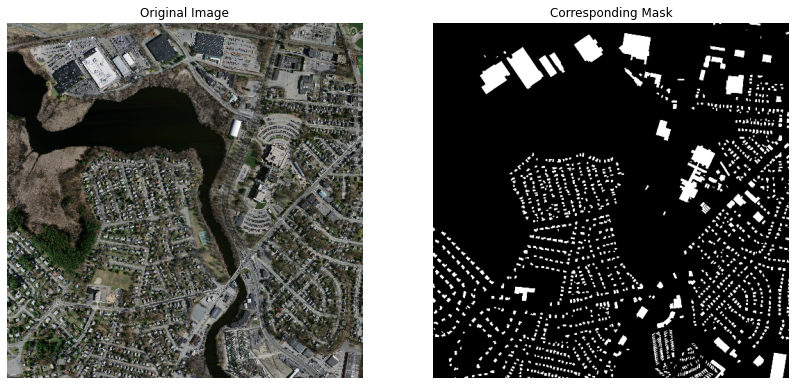

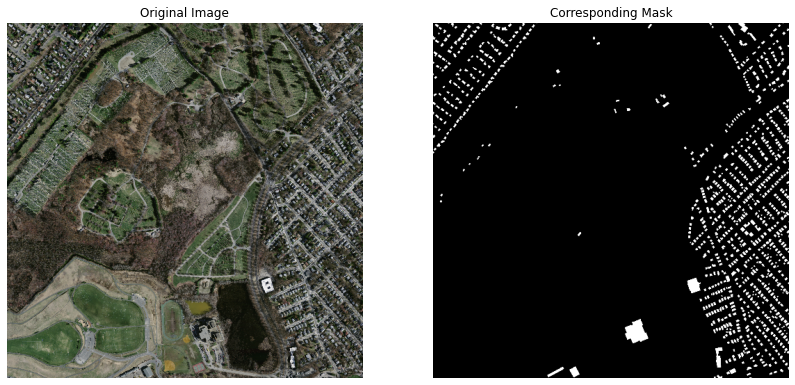

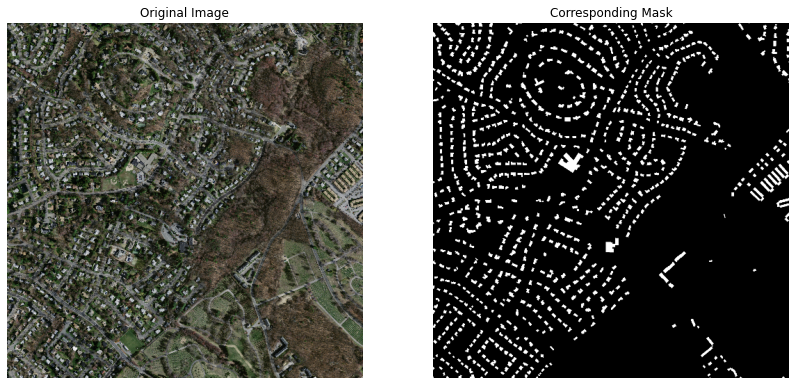

In [ ]:
# instantiates image visualization object
visuals = ImageVisualization()
# visualize images and masks
image_masks_visuals = visuals.get_plot_two_images(train_images, train_masks)

## 4. Data Augmentation

In [ ]:
class DataAugmentation(object):
    """
    This is a blueprint for augmenting images
    """
    def __init__(self, MASKS = None, IMAGES = None):
        pass
        
    def get_horizontal_flip(self, 
                            images,
                            masks):
        """
        This method flips images and the corresponding masks horizontally
        :params: buildings aroel images with correpsonding masks
        :returns: horizontally flipped images and masks
        """
        
        # flip images horizontally 
        IMAGES = np.append(images, [ np.fliplr(img) for img in images], axis=0)

        # flips masks horizontally
        MASKS = np.append(masks, [ np.fliplr(msk) for msk in masks], axis=0)

        return IMAGES, MASKS
    
    
    def get_vertically_flip(self, 
                            images, 
                            masks):
        """
        This method flips images and the corresponding masks vertically
        :params: buildings aroel images with correpsonding masks
        :returns: flipped images and masks
        """

        # flip images vertically  
        IMAGES = np.append(images, [ np.flipud(img) for img in images], axis=0)

        # flips masks vertically
        MASKS = np.append(masks, [ np.flipud(msk) for msk in masks], axis=0)

        return IMAGES, MASKS

    def get_augmentation(self, images, masks):
        """
        This method performs both horizontal and vertical flip
        :params: buildings arial images with correpsonding masks
        """
        
        # get the images and masks after performing  horizontal flip
        hor_flipped_images, hor_flipped_masks  = self.get_horizontal_flip(images, masks)

        # get the images and masks after performing  vertical flip
        ver_flipped_images,  ver_flipped_masks  = self.get_vertically_flip(hor_flipped_images, hor_flipped_masks)

        return  ver_flipped_images,  ver_flipped_masks 

### 4.1 Apply Horizontal Flip Augmentation

#### 4.1.1 Apply Horizontal and Vertical Flip Augmentation to Train Images and corresponding Masks

In [ ]:
# instantiate the images and masks data augmentation object
image_aug_object = DataAugmentation()

# get horizontally flipped/mirrored of train images and corresponding masks
train_images_aug, train_masks_aug = image_aug_object.get_augmentation(train_images, train_masks)


print("Train Images and  ")
print(train_images_aug.shape)
print(train_masks_aug.shape)

Train Images and  
(524, 512, 512, 3)
(524, 512, 512, 1)


#### 4.1.2 Apply Horizontal and Vertical Flip Augmentation to Validation Images and corresponding Masks

In [ ]:
# instantiate the images and masks data augmentation object
image_aug_object = DataAugmentation()

# get horizontal and vertical flipped validation images and corresponding masks
val_images_aug, val_masks_aug = image_aug_object.get_augmentation(val_images, val_masks)

print(val_images_aug.shape)
print(val_masks_aug.shape)

(40, 512, 512, 3)
(40, 512, 512, 1)


## 5. Building the U-Net Architecture

In [ ]:
class UnetModel(object):
    """
    This is a blueprint for the UNet model with pretrained weights from the VGG-16.
    """

    def __init__(self, 
                 IMAGE_DIMENSIONS, 
                 LEARNING_RATE,
                 DROPOUT_RATE):
        self.IMAGE_DIMENSIONS = IMAGE_DIMENSIONS
        self.DROPOUT_RATE = DROPOUT_RATE
        self.LEARNING_RATE = LEARNING_RATE
        self.SMOOTH = 1e-10
    
    def get_iou(self,A, B):
        """
        This method defines the intersection over union metric using the Jaccard metrics. The Jaccards metrics is the
        evaluation metrics which coomputes the overlapping between the ground truth and prediction.
        :returns: iou
        """
        # borrowed from https://www.kaggle.com/aglotero/another-iou-metric

        # get the ground and prediction values
        t , p  = A > 0,  B > 0 

        # used for smoothing the intersection over union
        
            
        # compute the truth value of t OR p element-wise.
        union = np.logical_or(t, p)

        # compute the truth value of A AND B element-wise.
        intersection = np.logical_and(A, B)
        
        # computes the intersection over union so that the probability sum up to 1.
        # to avoid invalid division (0/0), we smooth the intersection over union
        iou = (np.sum(intersection) + self.SMOOTH)/ (np.sum(union) + self.SMOOTH)

        return iou


    def get_iou_metric(self,ground_truth, pred_output):
        """
        This method computes the intersection over union of the model whilst training in  each iteration.
        :returns: the iou metric
        """

        # borrowed from https://www.kaggle.com/aglotero/another-iou-metric

        # get the predicted segments grester than 50%
        metric = [ground_truth, pred_output> 0.5]
        
        return tf.py_func(self.get_iou, metric, tf.float64)



    def get_conv2d_blocks(self, input_tensor, n_filters, kernel_size = (3,3) ):
        

        # get 
        x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
                padding='same',activation="relu")(input_tensor)

        x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
                padding='same',activation="relu")(x)
        return x

    def get_encoder(self):
        """
        This method loads pretrained weights from the VGG-16 and use it as an encoder or constracting path
        :returns: vgg weights
        """

        # idea from https://github.com/BBuf/Keras-Semantic-Segmentation/blob/fdfdb6939299cf99b3b1cf5de273c8bb6e731f5b/Models/VGGFCN8.py
        vgg = VGG16(weights='imagenet',include_top=False, input_shape = self.IMAGE_DIMENSIONS)
        vgg.layers.pop()
        vgg.trainable = False
        # iterates all  the layers and makes them untrainable to maintain weights from the VGG-16
        for layer in vgg.layers[:-4]:
            layer.trainable = False

        return vgg

    def get_unet_model(self):
        """
        This method upsamples the image to its original size e.g. 512 x 512 using the decoder.
        """
        
        # get pretrained weights from the VGG-16 (imagenet) and load it as an encoder
        vgg = self.get_encoder()

        """
        UPSAMPLING PATH OF THE U-NET
        """
        
        # we use the transposed convolution upsampling technique to increase the size of the feature map while halving the number of original channels. 
        u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(vgg.get_layer('block5_conv3').output)
        u1 = concatenate([u1,vgg.get_layer('block4_conv3').output])
        # adding the dropou hidden layer rate for training
        u1 = Dropout(self.DROPOUT_RATE)(u1)
        c1 = self.get_conv2d_blocks(u1, 512)

        # we use the transposed convolution upsampling technique to increase the size of the feature map while halving the number of original channels. 
        u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
        u2 = concatenate([u2,vgg.get_layer('block3_conv3').output])
        # adding the dropou hidden layer rate for training
        u2 = Dropout(self.DROPOUT_RATE)(u2)
        c2 = self.get_conv2d_blocks(u2, 256)

        # we use the transposed convolution upsampling technique to increase the size of the feature map while halving the number of original channels. 
        u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
        u3 = concatenate([u3,vgg.get_layer('block2_conv2').output])
        # adding the dropou hidden layer rate for training
        u3 = Dropout(self.DROPOUT_RATE)(u3)
        c3 = self.get_conv2d_blocks(u3, 128)

        # we use the transposed convolution upsampling technique to increase the size of the feature map while halving the number of original channels. 
        u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
        u4 = concatenate([u4,vgg.get_layer('block1_conv2').output])
        # adding the dropou hidden layer rate for training
        u4 = Dropout(self.DROPOUT_RATE)(u4)
        c4 = self.get_conv2d_blocks(u4, 64)

        # convolutional layer with (1,1) filter
        output = Conv2D(1, (1, 1), activation='sigmoid')(c4)
        
        unet = Model(vgg.input, output)
    
        return unet

    def get_compile_model(self):
        """
        This method compiles the U-Net model
        :returns: unet model
        """
        # get built unet network
        unet = self.get_unet_model()
        
        # compiles the unet model
        unet.compile(optimizer=optimizers.Adam(lr = self.LEARNING_RATE), 
                     loss = 'binary_crossentropy', 
                     metrics=['accuracy',self.get_iou_metric])
        
        return unet

In [ ]:
class ModelCallBacks(object):
    """
    This is a blueprint for training the U-Net architecture
    """
    def __init__(self, PATIENCE):
        self.PATIENCE = PATIENCE
        

    def get_model_checkpoints(self, PATH):
        """
        This method specifies where and how the modelcheckpoints should be saved.
        :params:
            path: path to get and save model weights
        :returns 
        """
        # get model checkpoints
        model_checkpoint  = ModelCheckpoint(PATH, 
                                            save_best_only=True, 
                                            monitor='val_loss', 
                                            mode='min', 
                                            verbose=1)
        # get early stopping to halt training when the model is no longer learning anything
        early_stopping = EarlyStopping(monitor='val_loss', 
                                       patience=self.PATIENCE,
                                       mode='min')

        # get the both model checkpoints and early stopping
        callbacks_list = [early_stopping, model_checkpoint]

        return callbacks_list

## 6. Setting Hyperparameters
We will train a model with and without data augmentation and evaluate how the model performs

In [ ]:
# INITIALIALIZING CONSTANT VARIABLES
img_dimensions = (512, 512, 3)
learning_rate = 1e-3
dropout_rate = 0.5
batch_size = 6
no_epochs = 100
patience = 25

#### 6.1 Get the U-Net Without Augmentation

In [ ]:
# get the unet model object
unet_model_object =  UnetModel(img_dimensions, learning_rate, dropout_rate)
# get the unet model
unet_model = unet_model_object.get_compile_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 3s 0us/step
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### 6.2 Get the U-Net With Augmentation

In [ ]:
# get the unet model object
unet_model_object =  UnetModel(img_dimensions, learning_rate, dropout_rate)
# get the unet model
aug_unet_model = unet_model_object.get_compile_model()

#### 6.3 Get Pretrained VGG-16 weights

In [ ]:
model_weights = "weights/model_best_checkpoint.h5"
model_weights_aug = "weights/aug_model_best_checkpoint.h5"

#### 6.4 Get Model Callbacks for U-Net Without Augmentation

In [ ]:
# get model callbacks objects
model_callbacks_object = ModelCallBacks(patience)
#get model call backs without augmentation
model_callback = model_callbacks_object.get_model_checkpoints(model_weights)

#### 6.5 Get Model Callbacks for U-Net With Augmentation

In [ ]:
# get model callbacks objects
model_callbacks_object = ModelCallBacks(patience)
#get model call backs withoutx augmentation
model_callback_aug = model_callbacks_object.get_model_checkpoints(model_weights_aug)

## 7. Train the U-Net

### 7.1 Fit the U-Net Model With or Without Augmentation

In [ ]:
# used to test the U-Net with and without augmentation
data_aug = False

In [ ]:
if not data_aug:
    # set the start time
    start = time.time()

    # train the U-Net without augmentation
    results = unet_model.fit(train_images, train_masks, 
                                batch_size = batch_size, 
                                epochs = no_epochs, 
                                validation_data = (val_images, val_masks), 
                                callbacks = model_callback)


    print("Elapsed Time", round((time.time() - start)/60,1), "minutes")
else:
    start = time.time()
    # train the U-Net with augmentation
    aug_results = aug_unet_model.fit(train_images_aug, train_masks_aug, 
                                batch_size = batch_size, 
                                epochs = no_epochs, 
                                validation_data = (val_images_aug, val_masks_aug), 
                                callbacks = model_callback_aug)
    print("Elapsed Time", round((time.time() - start)/60,1), "minutes")


Train on 131 samples, validate on 10 samples
Epoch 1/100
131/131 [==============================] - 122s 935ms/step - loss: 0.7933 - accuracy: 0.7895 - get_iou_metric: 0.0593 - val_loss: 0.2591 - val_accuracy: 0.9030 - val_get_iou_metric: 0.0588

Epoch 00001: val_loss improved from inf to 0.25906, saving model to weights/model_best_checkpoint.h5
Epoch 2/100
131/131 [==============================] - 68s 521ms/step - loss: 0.3575 - accuracy: 0.8390 - get_iou_metric: 0.0877 - val_loss: 0.2121 - val_accuracy: 0.9085 - val_get_iou_metric: 0.1208

Epoch 00002: val_loss improved from 0.25906 to 0.21210, saving model to weights/model_best_checkpoint.h5
Epoch 3/100
131/131 [==============================] - 68s 520ms/step - loss: 0.3111 - accuracy: 0.8490 - get_iou_metric: 0.1768 - val_loss: 0.1873 - val_accuracy: 0.9137 - val_get_iou_metric: 0.3065

Epoch 00003: val_loss improved from 0.21210 to 0.18734, saving model to weights/model_best_checkpoint.h5
Epoch 4/100
131/131 [==================

## 7. Model Evaluation 

In [ ]:
class ModelEvaluation(object):
    """
    This is a blueprint for evaluating models performance
    """
    def __init__(self):
        self.path = path
        self.title = title
        self.xlabels = xlabels
       

    def get_model_plot(self):
    

In [ ]:
def display_model_loss(num_epochs, history, title = None):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(num_epochs)

    plt.figure()
    plt.plot(epochs, loss, 'r',color = "red", label='Training loss')
    plt.plot(epochs, val_loss, 'r',color = "green", label='Validation loss')
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

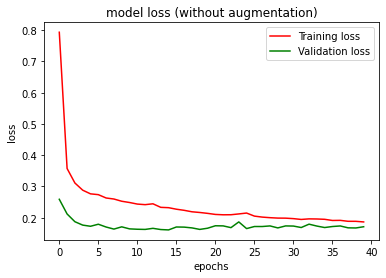

In [ ]:
display_model_loss(40, results, "model loss (without augmentation)")

In [ ]:
def get_iou(A,B):
    
    t = A>0
    p = B>0
    smooth = 1e-10
    union = np.logical_or(t, p)
    intersection = np.logical_and(A, B)
    iou = (np.sum(intersection) + smooth)/ (np.sum(union) + smooth)
    return iou

def iou_metric(mask, pred):
    metric = [mask, pred>0.5]
    return tf.py_func(get_iou, metric, tf.float64)

def get_model_weights(weights):
    model = load_model(weights, custom_objects={'iou_metric': iou_metric})
    return model

In [ ]:
no_aug_model = get_model_weights(model_weights)


def do_predictions(train_imgs, val_imgs, model,test_imgs):
        
    # do prediction on 70% of the dataset
    preds_train = model.predict(train_images, verbose=1)
    
    # the last 15% used as validation
    preds_val = model.predict(val_images, verbose=1)

    # prediction on 15% of the test dataset which was not used during training
    preds_test = model.predict(test_images, verbose=1)

    # threshold predictions
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    return preds_val_t, preds_test_t

AttributeError: ignored